<a href="https://colab.research.google.com/github/HANSOYE/Aiffel-exploration-report/blob/main/going_deeper_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from keras import models, layers
from keras import Input
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add

import os
import matplotlib.pyplot as plt
import numpy as np
import math

import tensorflow_datasets as tfds

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split = ('train[:80%]', 'train[80%:]'),
    with_info = True,
    as_supervised = True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteY5HXMP/cats_vs_dogs-train.tfrecord


  0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [ ]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [ ]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

# resnet 34

In [ ]:
input_tensor = Input(shape=(224, 224, 3), dtype='float32', name='input')
 
 
def conv1_layer(x):    
    x = ZeroPadding2D(padding=(3, 3))(x)
    x = Conv2D(64, (7, 7), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1,1))(x)
 
    return x   

In [ ]:
def conv2_layer(x):         
    x = MaxPooling2D((3, 3), 2)(x)     
 
    shortcut = x
 
    for i in range(3):
        if (i == 0):
            x = Conv2D(64, (3,3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(64, (3,3), strides=(1, 1), padding='same')(x)
            shortcut = Conv2D(64, (1, 1), strides=(1, 1), padding='same')(shortcut)            
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut])
            x = Activation('relu')(x)
            
            shortcut = x
 
        else:
            x = Conv2D(64, (3,3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)        
 
            x = Add()([x, shortcut])   
            x = Activation('relu')(x)  
 
            shortcut = x        
    
    return x

 
 

In [ ]:
def conv3_layer(x):        
    shortcut = x    
    
    for i in range(4):     
        if(i == 0):            
            x = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            shortcut = Conv2D(128, (1, 1), strides=(2, 2), padding='same')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)            
 
            x = Add()([x, shortcut])    
            x = Activation('relu')(x)    
 
            shortcut = x              
        
        else:
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])     
            x = Activation('relu')(x)
 
            shortcut = x      
            
    return x
 
 
 

In [ ]:

def conv4_layer(x):
    shortcut = x        
  
    for i in range(6):     
        if(i == 0):            
            x = Conv2D(256, (3, 3), strides=(2, 2), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        

            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            shortcut = Conv2D(256, (1, 1), strides=(2, 2), padding='same')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut]) 
            x = Activation('relu')(x)
 
            shortcut = x               
        
        else:
            x = Conv2D(256, (3,3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
  
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])    
            x = Activation('relu')(x)
 
            shortcut = x      
 
    return x
 
 


In [ ]:

def conv5_layer(x):
    shortcut = x    
  
    for i in range(3):     
        if(i == 0):            
            x = Conv2D(512, (3, 3), strides=(2, 2), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
 
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            shortcut = Conv2D(512, (1,1), strides=(2, 2), padding='same')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)            
 
            x = Add()([x, shortcut])  
            x = Activation('relu')(x)      
 
            shortcut = x               
        
        else:
            x = Conv2D(512, (3,3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)           
            
            x = Add()([x, shortcut]) 
            x = Activation('relu')(x)       
 
            shortcut = x                  
 
    return x
 
 
 

In [ ]:
x = conv1_layer(input_tensor)
x = conv2_layer(x)
x = conv3_layer(x)
x = conv4_layer(x)
x = conv5_layer(x)
 
x = GlobalAveragePooling2D()(x)
output_tensor = Dense(2, activation='softmax')(x)
 
resnet34 = Model(input_tensor, output_tensor)

In [ ]:
 
x = conv1_layer(input_tensor)
x = conv2_layer(x)
x = conv3_layer(x)
x = conv4_layer(x)
x = conv5_layer(x)
 
x = GlobalAveragePooling2D()(x)
output_tensor = Dense(2, activation='softmax')(x)
 
resnet34 = Model(input_tensor, output_tensor)

In [ ]:
BATCH_SIZE = 32
EPOCH = 20
# cats_vs_dogs dataset load
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)
resnet34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_34 = resnet34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
581/581 [==============================] - 152s 217ms/step - loss: 0.6530 - accuracy: 0.6211 - val_loss: 0.6483 - val_accuracy: 0.6359
Epoch 2/20
581/581 [==============================] - 124s 213ms/step - loss: 0.5958 - accuracy: 0.6784 - val_loss: 0.6330 - val_accuracy: 0.6580
Epoch 3/20
581/581 [==============================] - 123s 212ms/step - loss: 0.5484 - accuracy: 0.7169 - val_loss: 0.6150 - val_accuracy: 0.6916
Epoch 4/20
581/581 [==============================] - 123s 212ms/step - loss: 0.5135 - accuracy: 0.7474 - val_loss: 0.5389 - val_accuracy: 0.7310
Epoch 5/20
581/581 [==============================] - 123s 212ms/step - loss: 0.4705 - accuracy: 0.7761 - val_loss: 0.6011 - val_accuracy: 0.6963
Epoch 6/20
581/581 [==============================] - 123s 212ms/step - loss: 0.4075 - accuracy: 0.8139 - val_loss: 0.4735 - val_accuracy: 0.7668
Epoch 7/20
581/581 [==============================] - 123s 212ms/step - loss: 0.3531 - accuracy: 0.8432 - val_loss: 0.5339 -

# resnet 50

In [ ]:
input_tensor = Input(shape = (224, 224, 3), dtype = 'float32', name = 'input')

def conv1_layer(x):
    x = ZeroPadding2D(padding = (3, 3))(x)
    x = Conv2D(64, (7, 7), strides = (2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding = (1, 1))(x)

    return x


In [ ]:
def conv2_layer(x):
    x = MaxPooling2D((3, 3), 2)(x)

    shortcut = x

    for i in range(3):
        # conv2는 첫 번째 블록의 첫 번째 레이어도 stride = 1이다
        if (i == 0):
            x = Conv2D(64, (1, 1), strides = (1, 1), padding = 'valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(64, (3, 3), strides = (1, 1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(256, (1, 1), strides = (1,1), padding = 'valid')(x)
            shortcut = Conv2D(256, (1,1), strides = (1,1), padding = 'valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)

            x = Add()([x, shortcut])
            x = Activation('relu')(x)

            shortcut = x

        else:
            x = Conv2D(64, (1, 1), strides = (1,1), padding = 'valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(64, (3, 3), strides = (1, 1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(256, (1,1), strides = (1,1), padding = 'valid')(x)
            x = BatchNormalization()(x)

            x = Add()([x, shortcut])
            x = Activation('relu')(x)

            shortcut = x

    return x





In [ ]:
def conv3_layer(x):
    shortcut = x

    for i in range(4):
        # 첫 번째 블록
        # 의 첫 번째 레이어는 stride = 2이다
        if (i == 0):
            x = Conv2D(128, (1, 1), strides = (2, 2), padding = 'valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(128, (3, 3), strides = (1, 1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(512, (1, 1), strides = (1,1), padding = 'valid')(x)
            shortcut = Conv2D(512, (1,1), strides = (2,2), padding = 'valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)

            x = Add()([x, shortcut])
            x = Activation('relu')(x)

            shortcut = x

        #첫 번째 이외의 블록
        else:
            x = Conv2D(128, (1, 1), strides = (1,1), padding = 'valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(128, (3, 3), strides = (1, 1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(512, (1,1), strides = (1,1), padding = 'valid')(x)
            x = BatchNormalization()(x)

            x = Add()([x, shortcut])
            x = Activation('relu')(x)

            shortcut = x

    return x





In [ ]:
def conv4_layer(x):
    shortcut = x

    for i in range(6):
        if (i == 0):
            x = Conv2D(256, (1, 1), strides = (2, 2), padding = 'valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(256, (3, 3), strides = (1, 1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(1024, (1, 1), strides = (1,1), padding = 'valid')(x)
            shortcut = Conv2D(1024, (1,1), strides = (2,2), padding = 'valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)

            x = Add()([x, shortcut])
            x = Activation('relu')(x)

            shortcut = x

        else:
            x = Conv2D(256, (1, 1), strides = (1,1), padding = 'valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(256, (3, 3), strides = (1, 1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(1024, (1,1), strides = (1,1), padding = 'valid')(x)
            x = BatchNormalization()(x)

            x = Add()([x, shortcut])
            x = Activation('relu')(x)

            shortcut = x

    return x





In [ ]:
def conv5_layer(x):
    shortcut = x

    for i in range(3):
        if (i == 0):
            x = Conv2D(512, (1, 1), strides = (2, 2), padding = 'valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(512, (3, 3), strides = (1, 1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(2048, (1, 1), strides = (1,1), padding = 'valid')(x)
            shortcut = Conv2D(2048, (1,1), strides = (2,2), padding = 'valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)

            x = Add()([x, shortcut])
            x = Activation('relu')(x)

            shortcut = x

        else:
            x = Conv2D(512, (1, 1), strides = (1,1), padding = 'valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(512, (3, 3), strides = (1, 1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(2048, (1,1), strides = (1,1), padding = 'valid')(x)
            x = BatchNormalization()(x)

            x = Add()([x, shortcut])
            x = Activation('relu')(x)

            shortcut = x

    return x





In [ ]:
x = conv1_layer(input_tensor)
x = conv2_layer(x)
x = conv3_layer(x)
x = conv4_layer(x)
x = conv5_layer(x)

x = GlobalAveragePooling2D()(x)
output_tensor = Dense(2, activation = 'softmax')(x)

resnet50 = Model(input_tensor, output_tensor)
#resnet50.summary()

In [ ]:
resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_50 = resnet50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
581/581 [==============================] - 239s 371ms/step - loss: 0.7123 - accuracy: 0.5758 - val_loss: 0.7025 - val_accuracy: 0.5899
Epoch 2/20
581/581 [==============================] - 213s 367ms/step - loss: 0.6761 - accuracy: 0.6044 - val_loss: 0.6842 - val_accuracy: 0.5940
Epoch 3/20
581/581 [==============================] - 213s 366ms/step - loss: 0.6692 - accuracy: 0.6146 - val_loss: 0.6898 - val_accuracy: 0.5946
Epoch 4/20
581/581 [==============================] - 212s 366ms/step - loss: 0.6586 - accuracy: 0.6211 - val_loss: 0.6879 - val_accuracy: 0.5970
Epoch 5/20
581/581 [==============================] - 213s 366ms/step - loss: 0.6451 - accuracy: 0.6357 - val_loss: 0.7026 - val_accuracy: 0.6030
Epoch 6/20
581/581 [==============================] - 212s 366ms/step - loss: 0.6376 - accuracy: 0.6426 - val_loss: 1.0206 - val_accuracy: 0.5418
Epoch 7/20
581/581 [==============================] - 213s 366ms/step - loss: 0.6292 - accuracy: 0.6531 - val_loss: 0.9475 -

# resnet 34 plain

In [ ]:
input_tensor = Input(shape=(224, 224, 3), dtype='float32', name='input')
 
 
def conv1_layer(x):    
    x = ZeroPadding2D(padding=(3, 3))(x)
    x = Conv2D(64, (7, 7), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1,1))(x)
 
    return x   

def conv2_layer(x):         
    x = MaxPooling2D((3, 3), 2)(x)     

    for i in range(3):
        if (i == 0):
            x = Conv2D(64, (3,3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(64, (3,3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x) 
            x = Activation('relu')(x)
            
 
        else:
            x = Conv2D(64, (3,3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)     
            x = Activation('relu')(x)    
    
    return x

 
def conv3_layer(x):    
    
    for i in range(4):     
        if(i == 0):            
            x = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)     
            x = Activation('relu')(x)     
        
        else:
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)       
            x = Activation('relu')(x)
            
    return x
 
 

def conv4_layer(x):  
  
    for i in range(6):     
        if(i == 0):            
            x = Conv2D(256, (3, 3), strides=(2, 2), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        

            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)          
        
        else:
            x = Conv2D(256, (3,3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
  
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)       
            x = Activation('relu')(x)    
 
    return x
 
 

def conv5_layer(x):
    shortcut = x    
  
    for i in range(3):     
        if(i == 0):            
            x = Conv2D(512, (3, 3), strides=(2, 2), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
 
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)                
        
        else:
            x = Conv2D(512, (3,3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)                    
 
    return x
 
 
  
x = conv1_layer(input_tensor)
x = conv2_layer(x)
x = conv3_layer(x)
x = conv4_layer(x)
x = conv5_layer(x)
 
x = GlobalAveragePooling2D()(x)
output_tensor = Dense(2, activation='softmax')(x)
 
resnet34_plain = Model(input_tensor, output_tensor)
resnet34_plain.summary()


In [ ]:
resnet34_plain.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_34_plain = resnet34_plain.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
581/581 [==============================] - 132s 202ms/step - loss: 0.6903 - accuracy: 0.5553 - val_loss: 0.6968 - val_accuracy: 0.5463
Epoch 2/20
581/581 [==============================] - 117s 201ms/step - loss: 0.6832 - accuracy: 0.5628 - val_loss: 0.7393 - val_accuracy: 0.5208
Epoch 3/20
581/581 [==============================] - 117s 201ms/step - loss: 0.6739 - accuracy: 0.5832 - val_loss: 0.6974 - val_accuracy: 0.5733
Epoch 4/20
581/581 [==============================] - 117s 201ms/step - loss: 0.6621 - accuracy: 0.6060 - val_loss: 0.7286 - val_accuracy: 0.5620
Epoch 5/20
581/581 [==============================] - 117s 201ms/step - loss: 0.6542 - accuracy: 0.6191 - val_loss: 0.6430 - val_accuracy: 0.6317
Epoch 6/20
581/581 [==============================] - 117s 201ms/step - loss: 0.6443 - accuracy: 0.6339 - val_loss: 0.7642 - val_accuracy: 0.5405
Epoch 7/20
581/581 [==============================] - 117s 202ms/step - loss: 0.6389 - accuracy: 0.6363 - val_loss: 0.6540 -

# resnet 50 plain

In [ ]:
input_tensor = Input(shape = (224, 224, 3), dtype = 'float32', name = 'input')

def conv1_layer(x):
    x = ZeroPadding2D(padding = (3, 3))(x)
    x = Conv2D(64, (7, 7), strides = (2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding = (1, 1))(x)

    return x

def conv2_layer(x):
    x = MaxPooling2D((3, 3), 2)(x)

    for i in range(3):
        # conv2는 첫 번째 블록의 첫 번째 레이어도 stride = 1이다
        if (i == 0):
            x = Conv2D(64, (1, 1), strides = (1, 1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(64, (3, 3), strides = (1, 1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(256, (1, 1), strides = (1,1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

        else:
            x = Conv2D(64, (1, 1), strides = (1,1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(64, (3, 3), strides = (1, 1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(256, (1,1), strides = (1,1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

    return x



def conv3_layer(x):
    shortcut = x

    for i in range(4):
        # 첫 번째 블록
        # 의 첫 번째 레이어는 stride = 2이다
        if (i == 0):
            x = Conv2D(128, (1, 1), strides = (2, 2), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(128, (3, 3), strides = (1, 1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(512, (1, 1), strides = (1,1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

        #첫 번째 이외의 블록
        else:
            x = Conv2D(128, (1, 1), strides = (1,1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(128, (3, 3), strides = (1, 1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(512, (1,1), strides = (1,1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

    return x



def conv4_layer(x):
    shortcut = x

    for i in range(6):
        if (i == 0):
            x = Conv2D(256, (1, 1), strides = (2, 2), padding = 'valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(256, (3, 3), strides = (1, 1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(1024, (1, 1), strides = (1,1), padding = 'valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

        else:
            x = Conv2D(256, (1, 1), strides = (1,1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(256, (3, 3), strides = (1, 1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(1024, (1,1), strides = (1,1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

    return x



def conv5_layer(x):
    shortcut = x

    for i in range(3):
        if (i == 0):
            x = Conv2D(512, (1, 1), strides = (2, 2), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(512, (3, 3), strides = (1, 1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(2048, (1, 1), strides = (1,1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

        else:
            x = Conv2D(512, (1, 1), strides = (1,1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(512, (3, 3), strides = (1, 1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(2048, (1,1), strides = (1,1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

    return x



x = conv1_layer(input_tensor)
x = conv2_layer(x)
x = conv3_layer(x)
x = conv4_layer(x)
x = conv5_layer(x)

x = GlobalAveragePooling2D()(x)
output_tensor = Dense(2, activation = 'softmax')(x)

resnet50_plain = Model(input_tensor, output_tensor)


In [ ]:
resnet50_plain.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_50_plain = resnet50_plain.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

# 시각화

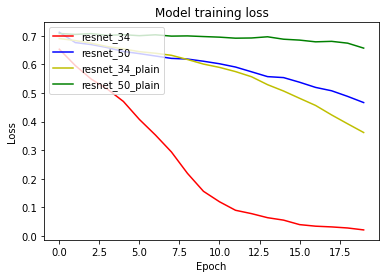

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_34.history['loss'], 'r')
plt.plot(history_50.history['loss'], 'b')
plt.plot(history_34_plain.history['loss'], 'y')
plt.plot(history_50_plain.history['loss'], 'g')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50', 'resnet_34_plain', 'resnet_50_plain'], loc='upper left')
plt.show()

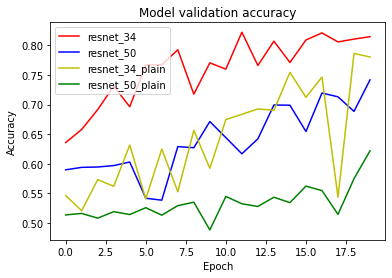

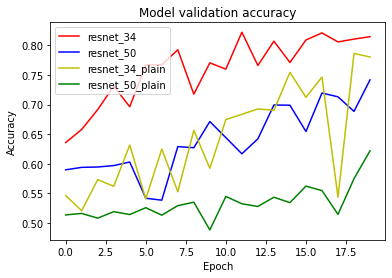

In [ ]:
plt.plot(history_34.history['val_accuracy'], 'r')
plt.plot(history_50.history['val_accuracy'], 'b')
plt.plot(history_34_plain.history['val_accuracy'], 'y')
plt.plot(history_50_plain.history['val_accuracy'], 'g')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50', 'resnet_34_plain', 'resnet_50_plain'], loc='upper left')
plt.show()